<a href="https://colab.research.google.com/github/Satya-Ganta03/project-legato-/blob/main/covid_19_diagnosis_vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import VGG19

## Data

In [ ]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/drive/MyDrive/CTScan/CovidData/'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (133).png,0,COVID
1,COVID/Covid (190).png,0,COVID
2,COVID/Covid (25).png,0,COVID
3,COVID/Covid (173).png,0,COVID
4,COVID/Covid (227).png,0,COVID


## Randomize the order of training set

In [ ]:
SEED = 59
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,non-COVID/Non-Covid (1074).png,1,non-COVID
1,COVID/Covid (564).png,0,COVID
2,COVID/Covid (1177).png,0,COVID
3,COVID/Covid (1169).png,0,COVID
4,COVID/Covid (839).png,0,COVID


## Display images of COVID

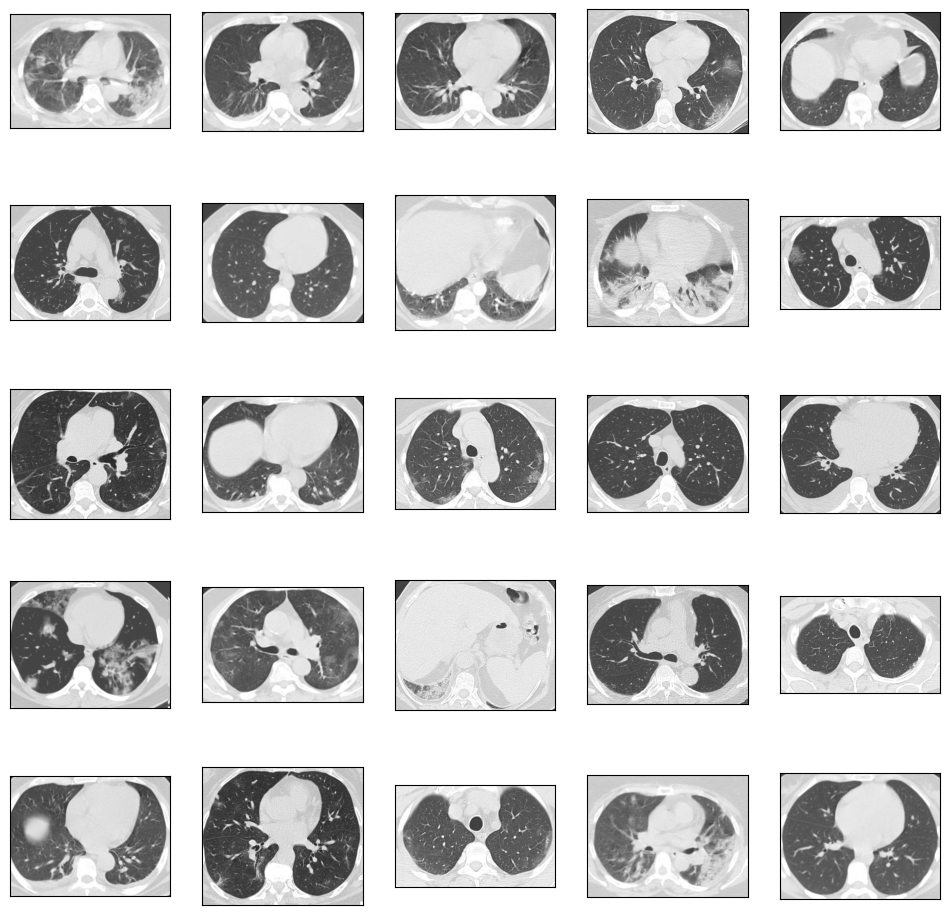

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 5, 5)

## Display images of non-COVID

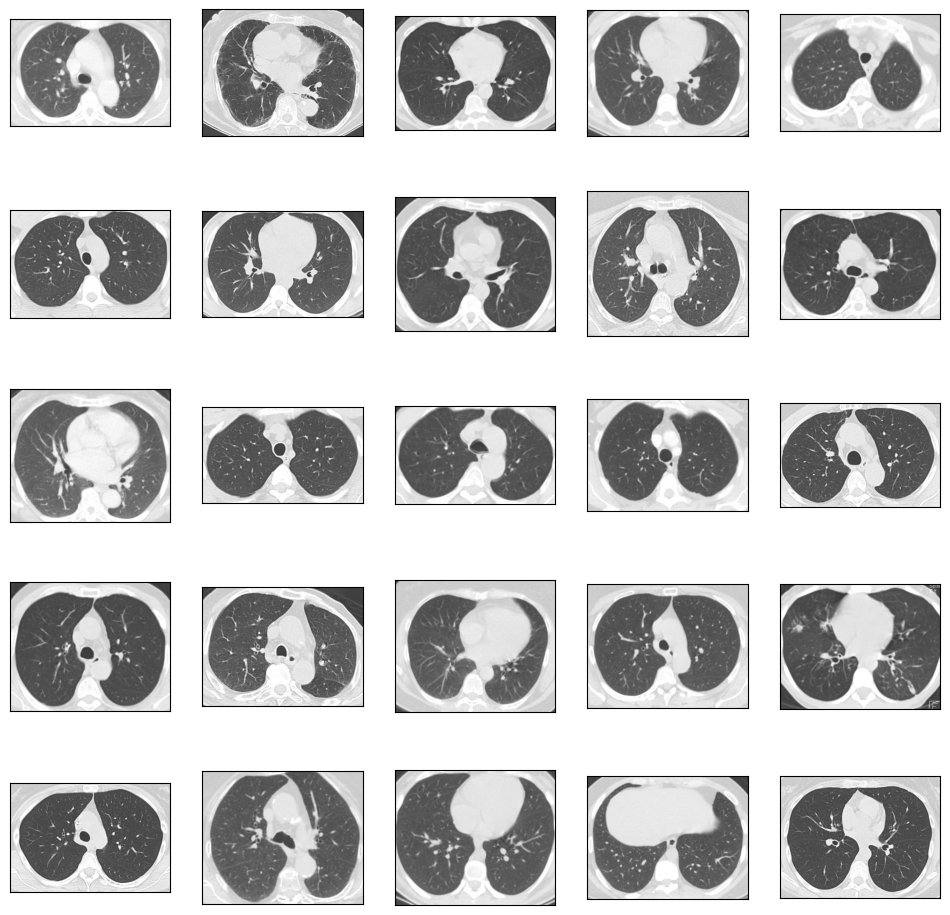

In [ ]:
# Displays first n images of class from training set
plot_defects('non-COVID', 5, 5)

## Image Read and Resize Function

In [ ]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

## Training Images

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [04:43,  8.76it/s]

Train Shape: (2481, 64, 64, 3)


## Converting Labels to Categorical

In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

## Train Test Splitting

In [ ]:
BATCH_SIZE = 256

# Split the train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

## 64*64 training images

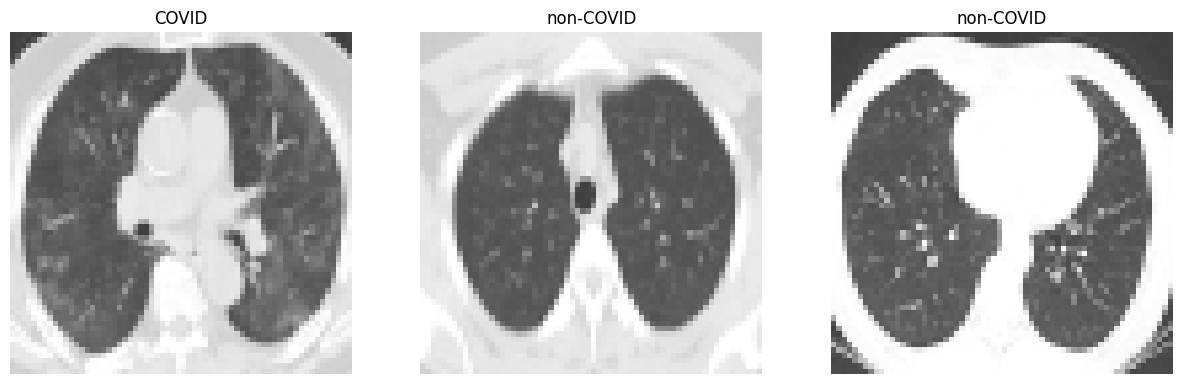

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [ ]:
EPOCHS = 50
SIZE=64
N_ch=3

## VGG19

In [ ]:
def build_vgg():
    vgg = VGG19(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)

    x = vgg(x)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)


    # model
    model = Model(input,output)

    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

## Data Augmentation and Fitting Model

In [ ]:
model = build_vgg()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/CTScan/CovidData/VGG19_2.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                              

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-15-9f6208b4e377>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),


Epoch 1/50

Epoch 1: val_loss improved from inf to 0.65745, saving model to /content/drive/MyDrive/CTScan/CovidData/VGG19_2.h5
7/7 - 31s - loss: 1.1362 - accuracy: 0.5399 - val_loss: 0.6575 - val_accuracy: 0.6157 - lr: 0.0020 - 31s/epoch - 4s/step
Epoch 2/50

Epoch 2: val_loss improved from 0.65745 to 0.61441, saving model to /content/drive/MyDrive/CTScan/CovidData/VGG19_2.h5
7/7 - 6s - loss: 0.9134 - accuracy: 0.6244 - val_loss: 0.6144 - val_accuracy: 0.6922 - lr: 0.0020 - 6s/epoch - 807ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 0.61441
7/7 - 4s - loss: 0.8700 - accuracy: 0.6470 - val_loss: 0.6538 - val_accuracy: 0.6157 - lr: 0.0020 - 4s/epoch - 563ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.61441 to 0.58526, saving model to /content/drive/MyDrive/CTScan/CovidData/VGG19_2.h5
7/7 - 4s - loss: 0.8520 - accuracy: 0.6620 - val_loss: 0.5853 - val_accuracy: 0.6901 - lr: 0.0020 - 4s/epoch - 536ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.58526 to 0.56592, s

## Final Loss and Accuracy

In [ ]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 0s 26ms/step - loss: 0.2838 - accuracy: 0.8712
Final Loss: 0.28382745385169983, Final Accuracy: 0.8712273836135864


## Confusion Matrix

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [ ]:
'''FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.values.sum() - (FP + FN + TP)'''

TN = cm[0][0]
#print(TN)
FN = cm[1][0]
#print(FN)
TP = cm[1][1]
#print(TP)
FP = cm[0][1]
#print(FP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print(TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP)
print(TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
print(FNR)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print(ACC)

0.8547717842323651
0.88671875
0.14522821576763487
0.8712273641851107


## Accuracy and Loss Curve

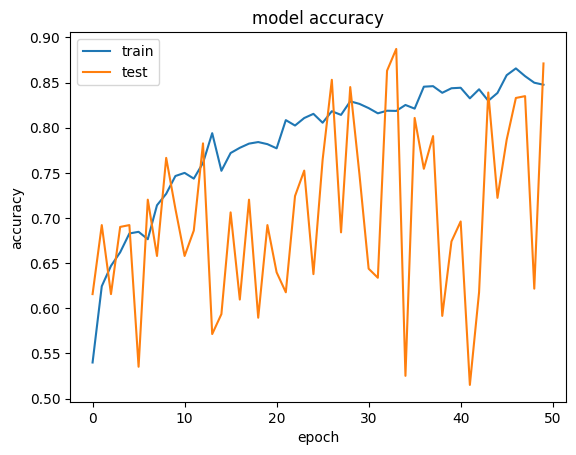

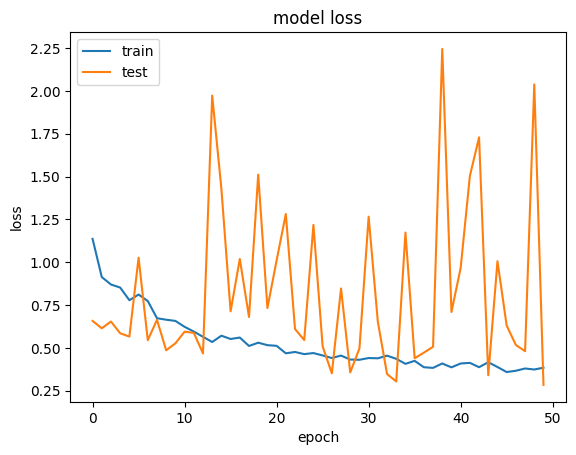

In [ ]:
# accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction from Image

1/1 [==============================] - 0s 419ms/step
[0.4129977 0.5870023]


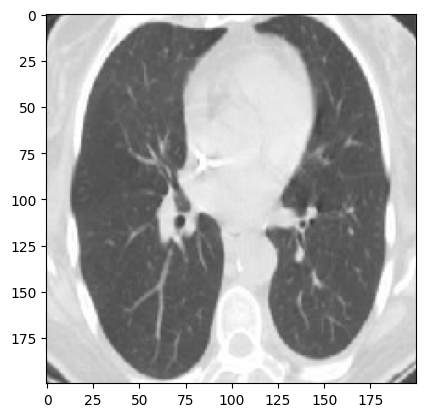

Prediction: Non Covid-19


In [ ]:
from skimage import io
#from keras.preprocessing import image
import keras.utils as image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/content/drive/MyDrive/CTScan/CovidData/non-COVID/Non-Covid (1166).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/drive/MyDrive/CTScan/CovidData/non-COVID/Non-Covid (1166).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)

print('Prediction:',disease_class[ind])